In [ ]:
# cell to install cv2

#pip install opencv-python


SyntaxError: invalid syntax (2295793481.py, line 3)

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [16]:
def sift_with_ransac_fundamental(img1_path, img2_path):
    """
    Detect keypoints using SIFT, match them, and estimate the fundamental matrix
    using RANSAC.

    Returns:
        F: The fundamental matrix estimated from inlier correspondences.
        pts1_inliers: Nx2 array of inlier correspondences in image 1.
        pts2_inliers: Nx2 array of inlier correspondences in image 2.
    """
    # 1. Load Images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
    
    if img1 is None or img2 is None:
        raise IOError("Could not load images. Check file paths.")

    # 2. Create SIFT detector
    sift = cv2.SIFT_create()

    # 3. Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 4. Match descriptors using BFMatcher (knnMatch for ratio test)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # 5. Lowe's Ratio Test
    good_matches = []
    ratio_thresh = 0.75
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # 6. Extract matched keypoints
    pts1 = []
    pts2 = []
    for match in good_matches:
        pts1.append(keypoints1[match.queryIdx].pt)
        pts2.append(keypoints2[match.trainIdx].pt)

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    # 7. Estimate Fundamental Matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)

    # 8. Inliers
    inlier_mask = mask.ravel().astype(bool)
    pts1_inliers = pts1[inlier_mask]
    pts2_inliers = pts2[inlier_mask]

    return F, pts1_inliers, pts2_inliers


In [17]:
def normalize_points(points: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Normalize 2D points for numerical stability.
    
    Args:
        points: A numpy array of shape (N, 2)
        
    Returns:
        points_normalized: Normalized 2D points (N, 2)
        T: 3x3 normalization transformation matrix
    """
    mean = points.mean(axis=0)
    std = points.std(axis=0)
    T = np.array([[1/std[0], 0, -mean[0]/std[0]],
                  [0, 1/std[1], -mean[1]/std[1]],
                  [0, 0, 1]])
    points_homo = np.hstack([points, np.ones((points.shape[0], 1))])
    points_norm = (T @ points_homo.T).T
    points_normalized = points_norm[:, :2]
    return points_normalized, T


def unnormalize_F(F_norm: np.ndarray, T_a: np.ndarray, T_b: np.ndarray) -> np.ndarray:
    """
    Un-normalizes the fundamental matrix F given normalization matrices.
    
    Args:
        F_norm: Fundamental matrix computed from normalized coordinates.
        T_a: Normalization matrix for image A.
        T_b: Normalization matrix for image B.
        
    Returns:
        F_orig: Fundamental matrix in original coordinate scale.
    """
    F_orig = T_b.T @ F_norm @ T_a
    return F_orig


def estimate_fundamental_matrix(points_a: np.ndarray, points_b: np.ndarray) -> np.ndarray:
    """
    Estimate the fundamental matrix using the eight-point algorithm.
    
    Args:
        points_a: 2D points from image A, shape (N,2)
        points_b: 2D points from image B, shape (N,2)
        
    Returns:
        F: Estimated fundamental matrix (3x3)
    """
    # Normalize the points
    points_a_norm, T_a = normalize_points(points_a)
    points_b_norm, T_b = normalize_points(points_b)
    
    N = points_a_norm.shape[0]
    A = np.zeros((N, 9))
    for i in range(N):
        u, v = points_a_norm[i]
        u1, v1 = points_b_norm[i]
        A[i] = [u * u1, v * u1, u1, u * v1, v * v1, v1, u, v, 1]
    
    # Solve Af = 0 using SVD
    _, _, Vt = np.linalg.svd(A)
    F_normalized = Vt[-1].reshape(3, 3)
    
    # Enforce rank-2 constraint
    U, S, Vt = np.linalg.svd(F_normalized)
    S[2] = 0
    F_normalized_rank2 = U @ np.diag(S) @ Vt
    
    # Unnormalize F
    F = unnormalize_F(F_normalized_rank2, T_a, T_b)
    return F


In [33]:
def draw_epipolar_lines(img, lines, points, line_thickness=3, point_size=20):
    """
    Draw epipolar lines and corresponding points on an image with enhanced visibility.

    Args:
        img (numpy array): The input image.
        lines (numpy array): Epipolar lines in the form [a, b, c] for ax + by + c = 0.
        points (numpy array): Corresponding points (N,2) used for coloring.
        line_thickness (int): Thickness of the epipolar lines.
        point_size (int): Size of the points.

    Returns:
        numpy array: Image with epipolar lines and points drawn.
    """
    r, c = img.shape[:2]
    img_color = img.copy()

    for r_line, pt in zip(lines, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each line

        # Compute endpoints of the line segment within the image borders
        if r_line[1] != 0:
            x0, y0 = 0, int(-r_line[2] / r_line[1])
            x1, y1 = c, int(-(r_line[2] + r_line[0] * c) / r_line[1])
        else:  # Avoid division by zero for vertical lines
            x0, y0 = int(-r_line[2] / r_line[0]), 0
            x1, y1 = x0, r

        # Draw the epipolar line
        cv2.line(img_color, (x0, y0), (x1, y1), color, line_thickness)

        # Draw the corresponding point
        cv2.circle(img_color, tuple(pt.astype(int)), point_size, color, -1)

    return img_color

def compute_sampson_error(points_a, points_b, F):
    """
    Compute the Sampson error as an approximation of the geometric error.
    
    Args:
        points_a: 2D points from image A, shape (N,2)
        points_b: 2D points from image B, shape (N,2)
        F: Fundamental matrix (3x3)
    
    Returns:
        total_error: The total Sampson error across all correspondences.
    """
    total_error = 0
    points_a_homo = np.hstack([points_a, np.ones((points_a.shape[0], 1))])
    points_b_homo = np.hstack([points_b, np.ones((points_b.shape[0], 1))])
    
    for i in range(points_a.shape[0]):
        x = points_a_homo[i]
        x_prime = points_b_homo[i]
        Fx = F @ x
        Ftx = F.T @ x_prime
        numerator = (x_prime.T @ F @ x) ** 2
        denominator = Fx[0]**2 + Fx[1]**2 + Ftx[0]**2 + Ftx[1]**2
        total_error += numerator / denominator
    return total_error


Fundamental Matrix from RANSAC:
 [[-1.20486903e-07 -4.15197197e-06  4.03134585e-03]
 [ 5.27096135e-06 -1.16232292e-07 -1.10974190e-02]
 [-4.71193421e-03  9.91448076e-03  1.00000000e+00]]
Number of RANSAC inliers: 60

Refined Fundamental Matrix (Eight-Point on inliers):
 [[-4.61983326e-08 -1.53775595e-06  1.49786502e-03]
 [ 1.95015074e-06 -4.59171725e-08 -4.09701747e-03]
 [-1.74483980e-03  3.66568665e-03  3.66211579e-01]]


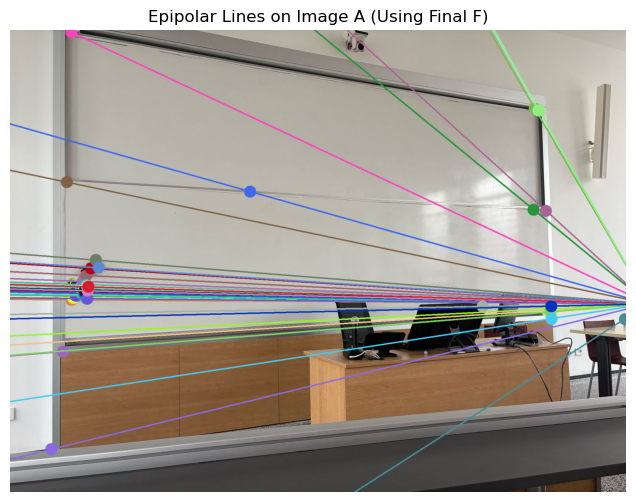

Sampson Error for Final F: 6.690209414387209


In [40]:
# File paths to your images
img1_path = "../data/imga.jpg"
img2_path = "../data/imgb.jpg"

# 1. SIFT + RANSAC to get fundamental matrix and inliers
F_ransac, pts1_inliers, pts2_inliers = sift_with_ransac_fundamental(img1_path, img2_path)
print("Fundamental Matrix from RANSAC:\n", F_ransac)
print("Number of RANSAC inliers:", len(pts1_inliers))

points_a = pts1_inliers
points_b = pts2_inliers
# 2. (Optional) Re-estimate using the eight-point algorithm on inliers
F_eight = estimate_fundamental_matrix(points_a, points_b)
print("\nRefined Fundamental Matrix (Eight-Point on inliers):\n", F_eight)

# Decide which F to use for visualization / error:
F_final = F_eight  # or F_ransac

# 3. Load images in color (for epipolar line drawing)
img_a_color = cv2.imread(img1_path)
img_b_color = cv2.imread(img2_path)

# Convert to RGB for plotting
img_a_rgb = cv2.cvtColor(img_a_color, cv2.COLOR_BGR2RGB)
img_b_rgb = cv2.cvtColor(img_b_color, cv2.COLOR_BGR2RGB)

# 4. Visualize epipolar lines in Image A for points in Image B
points_b_homo = np.hstack([pts2_inliers, np.ones((pts2_inliers.shape[0], 1))])
lines_in_A = (F_final.T @ points_b_homo.T).T  # Nx3
img_a_epilines = draw_epipolar_lines(img_a_rgb, lines_in_A, pts1_inliers)

plt.figure(figsize=(8, 6))
plt.imshow(img_a_epilines)
plt.title("Epipolar Lines on Image A (Using Final F)")
plt.axis("off")
plt.show()

# 5. Compute Sampson error for final F
sampson_err = compute_sampson_error(pts1_inliers, pts2_inliers, F_final)
print("Sampson Error for Final F:", sampson_err)


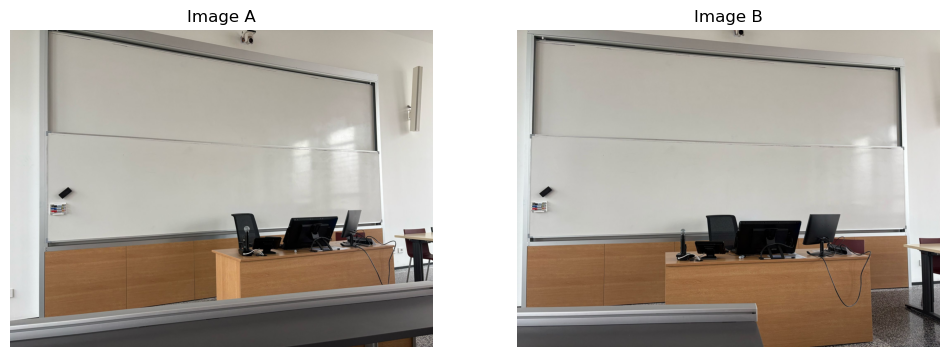

In [41]:
# Display images without epipolar lines
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img_a_rgb)
axs[0].set_title("Image A")
axs[0].axis("off")

axs[1].imshow(img_b_rgb)
axs[1].set_title("Image B")
axs[1].axis("off")

plt.show()



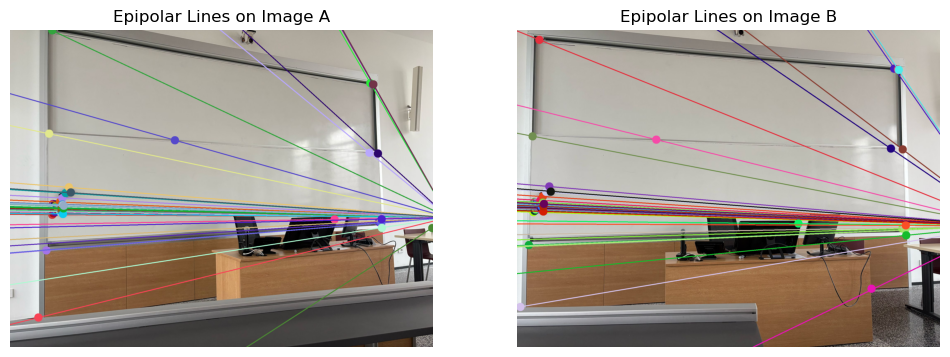

In [42]:
# Compute epipolar lines in image A for each point in image B
points_b_homo = np.hstack([points_b, np.ones((points_b.shape[0], 1))])
lines_in_A = (F_eight.T @ points_b_homo.T).T  # Each row corresponds to an epipolar line [a, b, c]

# Compute epipolar lines in image B for each point in image A
points_a_homo = np.hstack([points_a, np.ones((points_a.shape[0], 1))])
lines_in_B = (F_eight @ points_a_homo.T).T  # Each row corresponds to an epipolar line [a, b, c]

# Draw epipolar lines on both images
img_a_with_lines = draw_epipolar_lines(img_a_rgb, lines_in_A, points_a)
img_b_with_lines = draw_epipolar_lines(img_b_rgb, lines_in_B, points_b)

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img_a_with_lines)
axs[0].set_title("Epipolar Lines on Image A")
axs[0].axis("off")

axs[1].imshow(img_b_with_lines)
axs[1].set_title("Epipolar Lines on Image B")
axs[1].axis("off")

plt.show()
